In [ ]:
import gc
import os
import operator

from glob import glob

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from pandas.core.categorical import Categorical
from scipy.sparse import csr_matrix, hstack

In [1]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}

# Features used in training
categorical_features = ['app', 'device', 'os', 'channel']
numerical_features = ['clicks_by_ip']

def sparse_dummies(df, column):
    """Returns sparse OHE matrix for the column of the dataframe"""
    categories = Categorical(df[column])
    column_names = np.array([f"{column}_{str(i)}" for i in range(len(categories.categories))])
    N = len(categories)
    row_numbers = np.arange(N, dtype=np.int)
    ones = np.ones((N,))
    return csr_matrix((ones, (row_numbers, categories.codes))), column_names

df_train = pd.read_csv('../data/raw/train.csv', usecols=to_read, dtype=dtypes, parse_dates=to_parse)

# Example of numerical feature
clicks_by_ip = df_train.groupby(['ip']).size().rename('clicks_by_ip', inplace=True)
df_train = df_train.join(clicks_by_ip, on='ip')

matrices = []
all_column_names = []
# creates a matrix per categorical feature
for c in categorical_features:
    matrix, column_names = sparse_dummies(df_train, c)
    matrices.append(matrix)
    all_column_names.append(column_names)

# appends a matrix for numerical features (one column per feature)
matrices.append(csr_matrix(df_train[numerical_features].values, dtype=float))
all_column_names.append(df_train[numerical_features].columns.values)

train_sparse = hstack(matrices, format="csr")
feature_names = np.concatenate(all_column_names)
del matrices, all_column_names

X = train_sparse
y = df_train['is_attributed']

del df_train
gc.collect()

# Create binary training and validation files for XGBoost
x1, y1 = X[:train_size], y.iloc[:train_size]
dm1 = xgb.DMatrix(x1, y1, feature_names=feature_names)
dm1.save_binary('train.bin')
del dm1, x1, y1
gc.collect()

x2, y2 = X[train_size:], y.iloc[train_size:]
dm2 = xgb.DMatrix(x2, y2, feature_names=feature_names)
dm2.save_binary('validate.bin')
del dm2, x2, y2, X, y
gc.collect()

# XGBoost parameters example
params = {
    'eta': 0.3,
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'max_leaves': 1000,  
    'max_depth': 0, 
    'subsample': 0.9, 
    'alpha':1,
    'objective': 'binary:logistic', 
    'scale_pos_weight':100,
    'eval_metric': 'auc', 
    'nthread':16,
    'silent': 1
}

In [2]:
# Pointers to binary files for training and validation
# They won't be loaded into Python environment but passed directly to XGBoost
dmtrain = xgb.DMatrix('train.bin', feature_names=feature_names)
dmvalid = xgb.DMatrix('validate.bin', feature_names=feature_names)

# Training process
watchlist = [(dmtrain, 'train'), (dmvalid, 'valid')]
model = xgb.train(params, dmtrain, 50, watchlist, maximize=True, early_stopping_rounds=10, verbose_eval=1)

[0]	train-auc:0.971783	valid-auc:0.967348
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.972359	valid-auc:0.968148
[2]	train-auc:0.972898	valid-auc:0.968262
[3]	train-auc:0.973283	valid-auc:0.968606
[4]	train-auc:0.973542	valid-auc:0.968695
[5]	train-auc:0.973809	valid-auc:0.968882
[6]	train-auc:0.97414	valid-auc:0.969127
[7]	train-auc:0.97441	valid-auc:0.969234
[8]	train-auc:0.974761	valid-auc:0.969416
[9]	train-auc:0.975415	valid-auc:0.969733
[10]	train-auc:0.975863	valid-auc:0.969835
[11]	train-auc:0.976264	valid-auc:0.969859
[12]	train-auc:0.976675	valid-auc:0.969922
[13]	train-auc:0.97705	valid-auc:0.969913
[14]	train-auc:0.97747	valid-auc:0.969975
[15]	train-auc:0.977911	valid-auc:0.970018
[16]	train-auc:0.978283	valid-auc:0.970012
[17]	train-auc:0.978695	valid-auc:0.970022
[18]	train-auc:0.979005	valid-auc:0.970021
[19]	train-auc:0.979259	valid-auc:0.969934
[20]	train-

In [3]:
# Feature importance as a DataFrame
importance = sorted(model.get_fscore().items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
print(df.sort_values('fscore', ascending=False).head(10))

          feature    fscore
448  clicks_by_ip  0.383526
447         os_19  0.024453
446         os_13  0.023023
445         os_22  0.017625
444         os_17  0.014765
443         os_18  0.013335
442      device_1  0.012870
441         os_16  0.010689
440         os_25  0.010618
439         os_14  0.009867


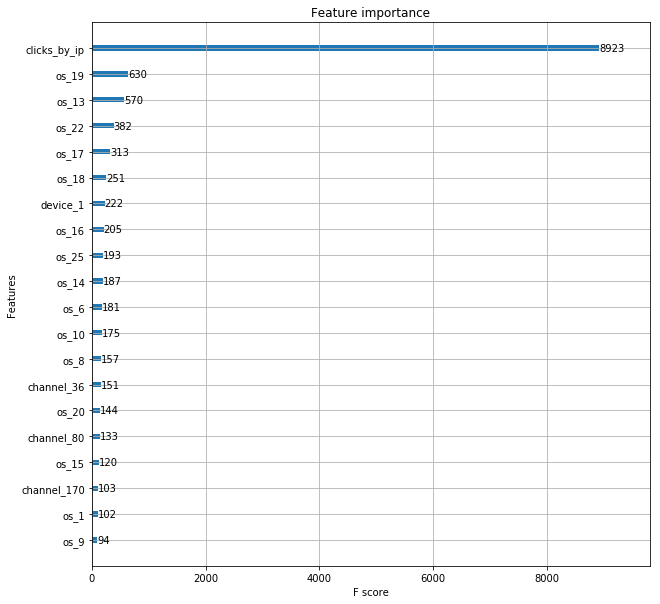

In [4]:
# Feature importance as a plot
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax, max_num_features=20)
plt.savefig('importance.png', format="png")